In [1]:
import concurrent
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy as sp
import queue
import time
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets
from threading import Thread
from tqdm.notebook import tqdm
from ipywidgets import IntProgress
from IPython.display import display
from typing import List, Tuple, Dict, Any, Generator, Callable
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
from typing import List, Tuple
from pyDOE3 import *
import torch

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1063f4110>>
Traceback (most recent call last):
  File "/Users/none/Documents/llama3-scheduling/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# Enable dynamic CUDA shared allocations and enforce error reporting for CUDA operations
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
models = [
  "meta-llama/Llama-3.2-1B",
  "meta-llama/Llama-3.2-3B",
  "meta-llama/Llama-3.1-8B",
]

batch_sizes = [
  1,
  4,
  8,
]

max_new_tokens_list = [
  100,
  250,
  500,
]

load_in_bits = [4, 8, None]

configurations = fullfact([
    len(models),
    len(batch_sizes),
    len(max_new_tokens_list),
    len(load_in_bits)
])

configurations

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [2., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.],
       [2., 1., 0., 0.],
       [0., 2., 0., 0.],
       [1., 2., 0., 0.],
       [2., 2., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 1., 0.],
       [2., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 1., 1., 0.],
       [2., 1., 1., 0.],
       [0., 2., 1., 0.],
       [1., 2., 1., 0.],
       [2., 2., 1., 0.],
       [0., 0., 2., 0.],
       [1., 0., 2., 0.],
       [2., 0., 2., 0.],
       [0., 1., 2., 0.],
       [1., 1., 2., 0.],
       [2., 1., 2., 0.],
       [0., 2., 2., 0.],
       [1., 2., 2., 0.],
       [2., 2., 2., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 1.],
       [2., 0., 0., 1.],
       [0., 1., 0., 1.],
       [1., 1., 0., 1.],
       [2., 1., 0., 1.],
       [0., 2., 0., 1.],
       [1., 2., 0., 1.],
       [2., 2., 0., 1.],
       [0., 0., 1., 1.],
       [1., 0., 1., 1.],
       [2., 0., 1., 1.],
       [0., 1., 1., 1.],


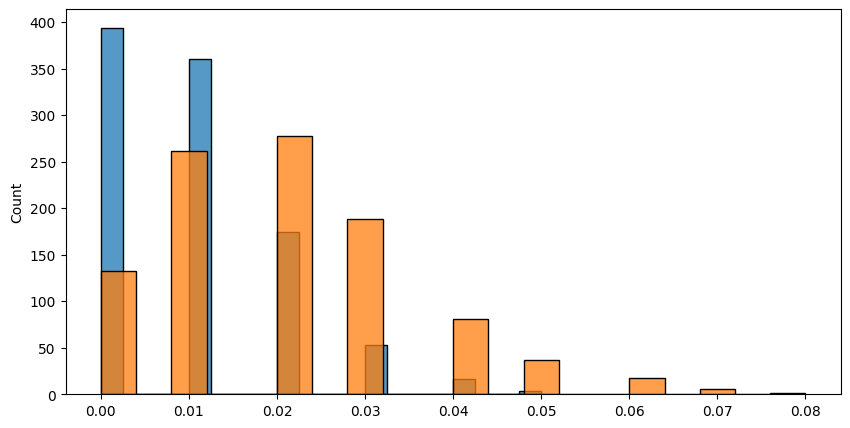

In [ ]:
inter_arrival_time = np.random.poisson(1, int(1e3)) / 100
service_time = np.random.poisson(2, int(1e3)) / 100

plt.figure(figsize=(10, 5))

sns.histplot(
    inter_arrival_time,
    bins=20,
)

sns.histplot(
    service_time,
    bins=20,
)

plt.show()

In [ ]:
df = pd.read_csv("drive/MyDrive/openrewriteeval_aaai24.csv")
df

In [ ]:
example_template = jinja2.Template(
    textwrap.dedent(
        """Instruction: Rewrite the given text while keeping the same meaning. Do not write anything else!

        Given text: {{ review }}

        Rewritten text: """
    )
)

df["processed"] = df["source"].apply(lambda x: example_template.render(review=x))

ds = datasets.Dataset.from_pandas(df)
ds

In [ ]:
class Service:
    def __init__(self, model: AutoModelForCausalLM, tokenizer: AutoTokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def load_model(
        self,
        model_name: str,
        quantization: int = 8
    ) -> Tuple[AutoTokenizer, AutoModelForCausalLM]:
        assert quantization in [4, 8], "Quantization must be either 4 or 8 bits"

        self.free()

        # Set up quantization configuration for the model
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=quantization == 4,
            load_in_8bit=quantization == 8
        )

        # Load the tokenizer with quantization and device mapping configurations
        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            device_map="auto",
            torch_dtype="auto",
            padding_side="left",
            quantization_config=quantization_config,
        )

        # Load the model with the same quantization and device configurations
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            torch_dtype="auto",
            quantization_config=quantization_config,
        )

        # Ensure the tokenizer has a pad token, fallback to EOS if missing
        tokenizer.pad_token = tokenizer.eos_token if tokenizer.pad_token is None else tokenizer.pad_token

        return tokenizer, model
    
    def __call__(self, batch: List[str], max_new_tokens: int) -> List[str]:
        # Tokenize the batch input text
        tokenized_text = self.tokenizer.batch_encode_plus(
            batch,
            return_tensors="pt",
            padding=True
        )

        # Prepare input IDs and attention masks on the appropriate device
        input_ids = tokenized_text["input_ids"].to(self.model.device)
        attention_mask = tokenized_text["attention_mask"].to(self.model.device)

        # Generate model outputs for the input text
        output_ids = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,      # Limit for text length
            temperature=1.0,                    # Lower for precise rewrites
            top_p=0.9,                          # Slightly tighter for coherence
            top_k=50                            # Focus on most probable tokens
        )

        # Decode the generated output text
        output_text = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        return output_text
    
    def free(self):
        del self.model
        del self.tokenizer

In [ ]:
class Server:
    def __init__(
            self,
            inter_arrival_time: np.ndarray,
            service_time: np.ndarray, 
            n_workers: int = 1,
            work_fn: Callable[[float], None] = lambda x: time.sleep(x)
        ):
        self.inter_arrival_time = inter_arrival_time
        self.service_time = service_time

        assert inter_arrival_time.shape[0] == service_time.shape[0]
        self.max_count = inter_arrival_time.shape[0]

        self.index = 0
        
        self.progress_bar = IntProgress(min=0, max=self.max_count) 
        self.job_queue = [queue.Queue() for _ in range(n_workers)]
        self.start_time = 0.
        self.running = False
        self.n_workers = n_workers
        self.work_fn = work_fn
         
    def _receive(self):
        """
        We simulate the inter arrival time by waiting for a delay specified in the dataframe
        """
        receive_time, job_time = next(self)
        time.sleep(receive_time)
        return job_time

    def submitter(self):
        """
        Submitter function that submits job to the only worker queue between sleeps dictated
        by the input dataframe.
        We return the time each job was submitted to compute how long it remained in the queue 
        afterwards.
        """
        queue = self.job_queue[0]
        result = np.zeros(self.max_count)
        submitter_index = 0
        for _ in range(self.max_count):
            task = self._receive()
            queue.put(task)
            result[submitter_index] = time.time() - self.start_time
            submitter_index += 1
        print("Done submitting")
        self.running = False # Signal to worker to stop running after emptying the queue
        return (result,)

    def worker(self, idx=0):
        """
        A worker function to handle the jobs put in the queue. Each worker has its own queue.
        """
        queue = self.job_queue[idx]
        result = np.empty(self.max_count)
        result[:] = np.nan
        consumer_index = 0
        while self.running or not queue.empty():
            if not queue.empty():
                task = queue.get()
                queue.task_done()
                result[consumer_index] = time.time() - self.start_time
                consumer_index += 1
                self.work_fn(task)
                self.progress_bar.value += 1  # signal to increment the progress bar
        print(f"done ({idx})")
        return result

    def run(self, save=True):
        """
        Method used to run the simulation. The submitter and every worker each get a separate thread.
        Note that due to python implementation the execution is not strictly concurrent, but we won't 
        bother with that here.
        """
        self.running = True
        display(self.progress_bar)
        self.start_time = time.time()
        
        # Start two concurrent threads, notice that worker is started before submitter
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_workers = [executor.submit(self.worker, i) for i in range(self.n_workers)]
            future_submitter = executor.submit(self.submitter)
            submit_res = future_submitter.result()
            worker_res = [worker.result() for worker in future_workers]
        
        res = pd.DataFrame(list(zip(*submit_res, *worker_res)))
        if save:
            res.to_csv("outputs_seconds_tst.csv",  index=False)
        return res
        
    def __iter__(self) -> Generator[Tuple[float, float], None, None]:
        """
        We use the iterator protocol to iterate over the dataframe
        """
        self.index = 0
    
    def __next__(self) -> Tuple[float, float]:
        """
        We use the iterator protocol to iterate over the dataframe
        """
        inter_arrival_time = self.inter_arrival_time[self.index]
        service_time = self.service_time[self.index]
        if self.index + 1 >= self.max_count:
            raise StopIteration
        self.index += 1
        return inter_arrival_time, service_time

In [ ]:
server = Server(
    inter_arrival_time,
    service_time,
    n_workers=1,
    work_fn=lambda x: time.sleep(x)
)
server.run()

IntProgress(value=0, max=1000)